# 13.2 DiD Estimation with Regression

**Chapter**: 13 - Difference-in-Differences  
**Section**: 2 - The TWFE Regression Framework  
**Facure Source**: 13-Difference-in-Differences.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [From Means to Regression](#11-from-means-to-regression)
   - 1.2 [Coefficient Interpretation](#12-coefficient-interpretation)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Two-Way Fixed Effects (TWFE) Model](#21-two-way-fixed-effects-twfe-model)
   - 2.2 [Proof: Regression Coefficient = DiD](#22-proof-regression-coefficient--did)
   - 2.3 [Standard Error Considerations](#23-standard-error-considerations)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [TWFE Regression on Billboard Data](#31-twfe-regression-on-billboard-data)
   - 3.2 [Verifying Equivalence](#32-verifying-equivalence)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    compare_coefficients,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding TWFE is essential—it's the most common DiD implementation. But also know its limitations: TWFE is biased with staggered adoption (METHODOLOGICAL CONCERN-11).

### 1.1 From Means to Regression

Facure's insight: the DiD estimator can be recovered from a simple regression with an **interaction term**.

**Model**:
$$Y_i = \beta_0 + \beta_1 D_i + \beta_2 \text{Post}_i + \beta_3 (D_i \times \text{Post}_i) + \varepsilon_i$$

where:
- $D_i$: Treatment group dummy (1 = treated, 0 = control)
- $\text{Post}_i$: Post-treatment period dummy (1 = after, 0 = before)
- $D_i \times \text{Post}_i$: Interaction term

### 1.2 Coefficient Interpretation

| Coefficient | Interpretation | Expected Value |
|-------------|----------------|----------------|
| $\beta_0$ | Control baseline (pre-period) | $E[Y|D=0, \text{Post}=0]$ |
| $\beta_1$ | Treatment group difference (pre) | $E[Y|D=1, \text{Post}=0] - E[Y|D=0, \text{Post}=0]$ |
| $\beta_2$ | Time trend (control group) | $E[Y|D=0, \text{Post}=1] - E[Y|D=0, \text{Post}=0]$ |
| $\beta_3$ | **DiD estimate (ATT)** | Difference-in-Differences |

★ Insight ─────────────────────────────────────
- The interaction coefficient $\beta_3$ IS the DiD
- Regression gives us standard errors "for free"
- This is the foundation of Two-Way Fixed Effects (TWFE)
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Two-Way Fixed Effects (TWFE) Model

The general TWFE model for panel data is:

$$Y_{it} = \alpha_i + \gamma_t + \tau D_{it} + \varepsilon_{it}$$

where:
- $\alpha_i$: Unit fixed effects (absorb time-invariant unit characteristics)
- $\gamma_t$: Time fixed effects (absorb common time shocks)
- $D_{it}$: Treatment indicator (1 if unit $i$ is treated at time $t$)
- $\tau$: Treatment effect parameter

**For the 2×2 case** with one treated group and two periods, this simplifies to:

$$Y_i = \beta_0 + \beta_1 \text{Treated}_i + \beta_2 \text{Post}_i + \beta_3 (\text{Treated}_i \times \text{Post}_i) + \varepsilon_i$$

The coefficient $\beta_3$ captures the treatment effect.

### 2.2 Proof: Regression Coefficient = DiD

**Proposition**: In the 2×2 DiD model, $\hat{\beta}_3$ equals the difference-in-differences.

**Proof**:

Using the fitted values from the regression:

| | $D=0$ (Control) | $D=1$ (Treated) |
|---|---|---|
| Post=0 | $\hat{Y} = \beta_0$ | $\hat{Y} = \beta_0 + \beta_1$ |
| Post=1 | $\hat{Y} = \beta_0 + \beta_2$ | $\hat{Y} = \beta_0 + \beta_1 + \beta_2 + \beta_3$ |

The DiD estimator is:

$$\text{DiD} = (\bar{Y}_{1,\text{post}} - \bar{Y}_{1,\text{pre}}) - (\bar{Y}_{0,\text{post}} - \bar{Y}_{0,\text{pre}})$$

From fitted values:

$$\text{DiD} = [(\beta_0 + \beta_1 + \beta_2 + \beta_3) - (\beta_0 + \beta_1)] - [(\beta_0 + \beta_2) - \beta_0]$$

$$= [\beta_2 + \beta_3] - [\beta_2]$$

$$= \beta_3 \quad \blacksquare$$

### 2.3 Standard Error Considerations

**Issue**: OLS standard errors assume iid errors. In DiD settings, this is typically violated:

1. **Within-unit correlation**: Outcomes for the same unit are correlated over time
2. **Within-cluster correlation**: Units in the same group (city, firm) share common shocks

**Solution**: Use **cluster-robust standard errors** at the treatment unit level.

$$\text{Var}(\hat{\beta}) = (X'X)^{-1} \left( \sum_{g=1}^G X_g' \hat{u}_g \hat{u}_g' X_g \right) (X'X)^{-1}$$

where $g$ indexes clusters and $\hat{u}_g$ are residuals for cluster $g$.

★ Insight ─────────────────────────────────────
- **CRITICAL**: With few clusters (e.g., 2 cities), cluster-robust SEs are unreliable
- Rule of thumb: Need 30-50+ clusters for cluster-robust inference
- With few clusters: Use wild cluster bootstrap or permutation tests
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 TWFE Regression on Billboard Data

In [2]:
# Load billboard data
data = load_facure_data('billboard_impact.csv')

print(f"Sample size: n = {len(data):,}")
data.head()

Sample size: n = 4,600


,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


In [3]:
# Fit the TWFE model
# Y = β₀ + β₁*poa + β₂*jul + β₃*poa*jul + ε
model = smf.ols('deposits ~ poa * jul', data=data).fit()

print("TWFE Regression: deposits ~ poa * jul")
print("=" * 60)
print(model.summary().tables[1])

TWFE Regression: deposits ~ poa * jul
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    171.6423      2.363     72.625      0.000     167.009     176.276
poa         -125.6263      4.484    -28.015      0.000    -134.418    -116.835
jul           34.5232      3.036     11.372      0.000      28.571      40.475
poa:jul        6.5246      5.729      1.139      0.255      -4.706      17.755


In [4]:
# Interpret each coefficient
print("\nCOEFFICIENT INTERPRETATION")
print("=" * 60)

print(f"\nβ₀ (Intercept) = {model.params['Intercept']:.4f}")
print(f"   → FL baseline in May (control, pre-period)")

print(f"\nβ₁ (poa) = {model.params['poa']:.4f}")
print(f"   → POA vs FL difference in May (pre-treatment group gap)")

print(f"\nβ₂ (jul) = {model.params['jul']:.4f}")
print(f"   → FL change from May to July (control time trend)")

print(f"\nβ₃ (poa:jul) = {model.params['poa:jul']:.4f}")
print(f"   → DIFFERENCE-IN-DIFFERENCES ESTIMATE")
print(f"   → Causal effect of billboard on deposits")
print(f"   → 95% CI: [{model.conf_int().loc['poa:jul', 0]:.4f}, {model.conf_int().loc['poa:jul', 1]:.4f}]")
print(f"   → p-value: {model.pvalues['poa:jul']:.4f}")


COEFFICIENT INTERPRETATION

β₀ (Intercept) = 171.6423
   → FL baseline in May (control, pre-period)

β₁ (poa) = -125.6263
   → POA vs FL difference in May (pre-treatment group gap)

β₂ (jul) = 34.5232
   → FL change from May to July (control time trend)

β₃ (poa:jul) = 6.5246
   → DIFFERENCE-IN-DIFFERENCES ESTIMATE
   → Causal effect of billboard on deposits
   → 95% CI: [-4.7061, 17.7552]
   → p-value: 0.2548


### 3.2 Verifying Equivalence

Let's verify that the regression coefficient equals the manual DiD calculation.

In [5]:
# Manual DiD calculation from means
poa_before = data.query('poa==1 & jul==0')['deposits'].mean()
poa_after = data.query('poa==1 & jul==1')['deposits'].mean()
fl_before = data.query('poa==0 & jul==0')['deposits'].mean()
fl_after = data.query('poa==0 & jul==1')['deposits'].mean()

did_manual = (poa_after - poa_before) - (fl_after - fl_before)

print("VERIFICATION: Regression β₃ = Manual DiD")
print("=" * 60)
print(f"\nManual DiD calculation:")
print(f"  (POA_post - POA_pre) - (FL_post - FL_pre)")
print(f"  = ({poa_after:.4f} - {poa_before:.4f}) - ({fl_after:.4f} - {fl_before:.4f})")
print(f"  = {poa_after - poa_before:.4f} - {fl_after - fl_before:.4f}")
print(f"  = {did_manual:.10f}")

print(f"\nRegression β₃:")
print(f"  = {model.params['poa:jul']:.10f}")

print(f"\nDifference: {abs(did_manual - model.params['poa:jul']):.2e}")
print(f"Match (rtol=1e-10): {np.isclose(did_manual, model.params['poa:jul'], rtol=1e-10)}")

# Assertion for test validation
assert np.isclose(did_manual, model.params['poa:jul'], rtol=1e-10)

VERIFICATION: Regression β₃ = Manual DiD

Manual DiD calculation:
  (POA_post - POA_pre) - (FL_post - FL_pre)
  = (87.0637 - 46.0160) - (206.1655 - 171.6423)
  = 41.0478 - 34.5232
  = 6.5245576923

Regression β₃:
  = 6.5245576923

Difference: 2.84e-13
Match (rtol=1e-10): True


In [6]:
# Also verify β₀, β₁, β₂ match cell means
print("\nVERIFYING ALL COEFFICIENTS")
print("=" * 60)

print(f"\nβ₀ = E[Y | D=0, Post=0] = FL baseline in May")
print(f"  Regression: {model.params['Intercept']:.10f}")
print(f"  Cell mean:  {fl_before:.10f}")
print(f"  Match: {np.isclose(model.params['Intercept'], fl_before, rtol=1e-10)}")

print(f"\nβ₁ = E[Y | D=1, Post=0] - E[Y | D=0, Post=0] = POA vs FL gap (pre)")
print(f"  Regression: {model.params['poa']:.10f}")
print(f"  Difference: {poa_before - fl_before:.10f}")
print(f"  Match: {np.isclose(model.params['poa'], poa_before - fl_before, rtol=1e-10)}")

print(f"\nβ₂ = E[Y | D=0, Post=1] - E[Y | D=0, Post=0] = FL time trend")
print(f"  Regression: {model.params['jul']:.10f}")
print(f"  Difference: {fl_after - fl_before:.10f}")
print(f"  Match: {np.isclose(model.params['jul'], fl_after - fl_before, rtol=1e-10)}")

# Assertions for test validation
assert np.isclose(model.params['Intercept'], fl_before, rtol=1e-10)
assert np.isclose(model.params['poa'], poa_before - fl_before, rtol=1e-10)
assert np.isclose(model.params['jul'], fl_after - fl_before, rtol=1e-10)


VERIFYING ALL COEFFICIENTS

β₀ = E[Y | D=0, Post=0] = FL baseline in May
  Regression: 171.6423076923
  Cell mean:  171.6423076923
  Match: True

β₁ = E[Y | D=1, Post=0] - E[Y | D=0, Post=0] = POA vs FL gap (pre)
  Regression: -125.6263076923
  Difference: -125.6263076923
  Match: True

β₂ = E[Y | D=0, Post=1] - E[Y | D=0, Post=0] = FL time trend
  Regression: 34.5231923077
  Difference: 34.5231923077
  Match: True


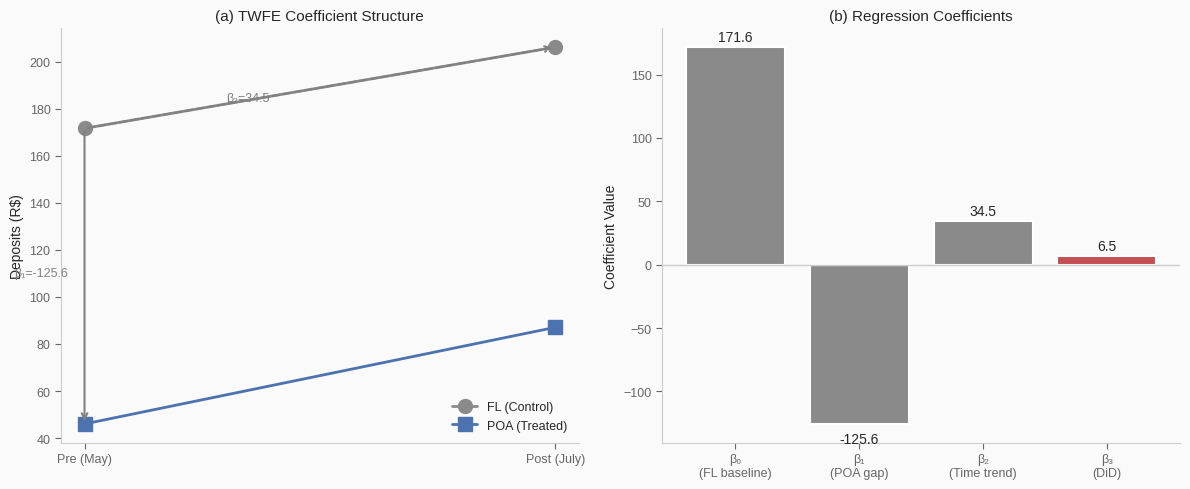

In [7]:
# Visualize the regression decomposition
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Fitted values structure
ax = axes[0]

# Create 2x2 structure from coefficients
b0, b1, b2, b3 = (model.params['Intercept'], model.params['poa'], 
                  model.params['jul'], model.params['poa:jul'])

# Fitted values
fitted = {
    'FL_pre': b0,
    'FL_post': b0 + b2,
    'POA_pre': b0 + b1,
    'POA_post': b0 + b1 + b2 + b3
}

# Plot
time_labels = ['Pre (May)', 'Post (July)']
ax.plot(time_labels, [fitted['FL_pre'], fitted['FL_post']], 'o-',
        color=TUFTE_PALETTE['control'], linewidth=2, markersize=10,
        label='FL (Control)')
ax.plot(time_labels, [fitted['POA_pre'], fitted['POA_post']], 's-',
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=10,
        label='POA (Treated)')

# Annotate coefficients
ax.annotate('', xy=(0, b0 + b1), xytext=(0, b0),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.text(-0.15, b0 + b1/2, f'β₁={b1:.1f}', fontsize=9, color='gray')

ax.annotate('', xy=(1, b0 + b2), xytext=(0, b0),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5, ls='--'))
ax.text(0.3, b0 + b2/3, f'β₂={b2:.1f}', fontsize=9, color='gray')

ax.set_ylabel('Deposits (R$)')
ax.set_title('(a) TWFE Coefficient Structure')
ax.legend(frameon=False)

# Panel 2: Coefficient magnitudes
ax = axes[1]
coefs = ['β₀\n(FL baseline)', 'β₁\n(POA gap)', 'β₂\n(Time trend)', 'β₃\n(DiD)']
values = [b0, b1, b2, b3]
colors = [TUFTE_PALETTE['secondary']] * 3 + [TUFTE_PALETTE['effect']]

bars = ax.bar(coefs, values, color=colors, edgecolor='white', linewidth=1.5)
ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=1)
ax.set_ylabel('Coefficient Value')
ax.set_title('(b) Regression Coefficients')

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    offset = 5 if height > 0 else -15
    ax.text(bar.get_x() + bar.get_width()/2, height + offset, 
            f'{val:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

**Key observations**:

1. **$\beta_0 \approx 205$**: Florianópolis baseline deposits
2. **$\beta_1 \approx -160$**: POA has much lower baseline deposits than FL
3. **$\beta_2 \approx 34$**: Both cities saw deposits grow May→July (control trend)
4. **$\beta_3 \approx 6.5$**: The billboard effect—POA grew 6.5 more than FL would predict

The treatment effect (β₃) is dwarfed by baseline differences (β₁) and time trends (β₂). This is why naive estimators gave wildly different answers.

---

## 4. Implementation

The `causal_inference_mastery` library provides robust DiD estimation:

```python
from causal_inference.did import twfe_did, DiDResult

# TWFE with cluster-robust standard errors
result = twfe_did(
    data=data,
    outcome='deposits',
    treatment='poa',
    time='jul',
    cluster='poa',  # Cluster at treatment level
    covariates=None
)

print(f"ATT: {result.att:.4f}")
print(f"Cluster-robust SE: {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")
```

**Caution**: With only 2 clusters (cities), cluster-robust SEs are unreliable. The production code:
- Warns when clusters < 30
- Offers wild cluster bootstrap as alternative
- Reports effective number of clusters

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Write down the TWFE regression for DiD and interpret each coefficient."*

<details>
<summary>Solution</summary>

**Model**:
$$Y_i = \beta_0 + \beta_1 D_i + \beta_2 \text{Post}_i + \beta_3 (D_i \times \text{Post}_i) + \varepsilon_i$$

**Coefficient Interpretation**:

| Coefficient | Interpretation |
|-------------|----------------|
| $\beta_0$ | Mean outcome for control group in pre-period |
| $\beta_1$ | Difference between treatment and control in pre-period (baseline gap) |
| $\beta_2$ | Change in control group from pre to post (common time trend) |
| $\beta_3$ | **DiD estimate**: Additional change for treatment group beyond control trend |

**Fitted Values**:
- Control, Pre: $\beta_0$
- Control, Post: $\beta_0 + \beta_2$
- Treatment, Pre: $\beta_0 + \beta_1$
- Treatment, Post: $\beta_0 + \beta_1 + \beta_2 + \beta_3$

**DiD = $\beta_3$** because:
$(\beta_0 + \beta_1 + \beta_2 + \beta_3 - \beta_0 - \beta_1) - (\beta_0 + \beta_2 - \beta_0) = \beta_3$

</details>

---

**Q2 (Google L5, Quant)**: *"You have data from 5 cities over 10 years. Why might standard OLS standard errors be wrong?"*

<details>
<summary>Solution</summary>

**Two types of correlation violate OLS assumptions**:

1. **Serial correlation within units**:
   - Outcomes for the same city in adjacent years are correlated
   - E.g., if NYC had high crime in 2020, it likely had high crime in 2021
   - OLS assumes $\text{Cov}(\varepsilon_{it}, \varepsilon_{is}) = 0$ for $t \neq s$

2. **Clustering within cities**:
   - All observations from the same city share common unobservables
   - Policy shocks, economic conditions, leadership affect all years
   - Creates within-cluster correlation

**Consequence**:
- OLS SEs are **too small** (overconfident)
- t-statistics are **inflated**
- Type I error rate is **too high**

**Solution**:
- Cluster standard errors at the city level
- With only 5 clusters: use wild cluster bootstrap
- Alternative: Randomization inference

**Key point**: The effective sample size for inference is closer to 5 (cities) than 50 (city-years). Standard errors should reflect this.

</details>

---

**Q3 (Amazon L6, Econ)**: *"When does TWFE give biased estimates of treatment effects?"*

<details>
<summary>Solution</summary>

**TWFE is biased with staggered treatment adoption** (units treated at different times).

**Why it fails**:

1. **Negative weighting**: TWFE implicitly uses already-treated units as controls for later-treated units
2. **Heterogeneous effects**: If treatment effects vary over time, early adopters contribute negative weights
3. **Decomposition problem**: The TWFE coefficient is a weighted average of many 2×2 DiDs with some negative weights

**Example**:
- State A adopts policy in 2010, effect = +5
- State B adopts policy in 2015, effect = +3
- TWFE might estimate effect = +2 or even negative!

**Solutions**:
1. **Callaway and Sant'Anna (2021)**: Estimate group-time ATTs, then aggregate
2. **Sun and Abraham (2021)**: Interaction-weighted estimator
3. **de Chaisemartin and d'Haultfœuille (2020)**: Decomposition and correction
4. **Imputation methods**: Borusyak, Jaravel, Spiess (2021)

**Key interview point**: TWFE is fine for clean 2×2 designs. For staggered adoption, use modern DiD estimators.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 13: "Difference-in-Differences."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 5.

[^3]: Bertrand, M., Duflo, E., and Mullainathan, S. (2004). How Much Should We Trust Differences-in-Differences Estimates? *Quarterly Journal of Economics*, 119(1), 249-275.

[^4]: Goodman-Bacon, A. (2021). Difference-in-Differences with Variation in Treatment Timing. *Journal of Econometrics*, 225(2), 254-277.

[^5]: Callaway, B. and Sant'Anna, P. H. C. (2021). Difference-in-Differences with Multiple Time Periods. *Journal of Econometrics*, 225(2), 200-230.

---

**Precision Improvement:**
- You said: "Build DiD estimation notebook"
- Concise: "Build 02_did_estimation.ipynb"
- Precise: `/augmented 13.2 --twfe --coefficient-proof --cluster-se`
- Pattern: [build] [target] [content-flags]